In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install lightgbm

In [ ]:
import importlib
# import risk_instruments
import pandas as pd
import numpy as np
import os
import sys
import pandas as pd
import plotly.io as pio
import seaborn as sns
import plotly.graph_objects as go


# from risk_instruments.database import DBconnect
# from risk_instruments.universal_analysis import woe_stab, woe_line
# from risk_instruments.express_analysis import gain_chart
# from configures import user, password
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import Pipeline
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats.distributions import chi2
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier, plot_importance
from scipy.stats import bernoulli, norm
from plotly.subplots import make_subplots
import lightgbm as lgb

# importlib.reload(risk_instruments.database)
pio.renderers.default='notebook'
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/scoring_model_data.csv'
df = pd.read_csv(path)

In [ ]:
df.head()

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
0,0,0,2019-01-01,0.991360,0.991360,0.0,1.0,1,1.000000,29.000000,29.0,-1.0,-1.0,51864.00,-5.898175,0.0,NaN,0.0
1,1,0,2019-01-01,0.928482,0.271159,0.0,0.0,1,0.296724,86.928571,1.0,-1.0,-1.0,1424742.89,-7.067999,0.0,49.0,1.0
2,2,0,2019-01-01,1.418333,0.079951,0.0,0.0,1,0.219805,-0.065789,-24.0,-1.0,20000.0,254827.00,-7.295431,0.0,47.0,16.0
3,3,0,2019-01-01,1.042425,0.230797,1.0,1.0,1,0.284345,116.615385,-5.0,-1.0,-1.0,138969.00,-5.073265,0.0,23.0,3.0
4,4,1,2019-01-01,0.960127,0.326562,2.0,2.0,1,0.334188,188.200000,1.0,-1.0,-1.0,53620.00,-7.226236,0.0,14.0,2.0


### Описание признаков

1. max_util (максимальная утилизация по КК)
2. avg_util (средняя утилизация по КК)
3. credits_2y (количество кредитов за последние 2 года)
4. credits_4y (количество кредитов за последние 4 года)
5. bad_history_credits_flg (наличие кредитов в подозрительных кредитных организациях)
6. other_util (отношение задолженности к сумме кредитов в других организациях)
7. avg_term (средний срок кредита)
8. min_term (минимальный срок кредита)
9. avg_limit_mortgage (средний лимит по ипотекам)
10. min_limit_mfo (минимальный лимит в мфо)
11. close_balance_amt (выплаченная сумма)
12. soc_dem_score (скоринговый балл основанный на соц-дем показателях)
13. max_delq_cnt (максимальное число просрочек по кредиту)
14. avg_active_time (среднее оставшееся время по открытам кредитам)
15. last_credit_time_years (время (в годах) с последнего закрытого кредита)

### Данные для построения приложены к домашнему заданию (data.csv)

Привет! В этом задании тебе предстоит построить модель для задачи предсказания дефолта клиента. Тебе предоставлен набор признаков и целевая переменная — факт выхода клиентов в просрочку глубины 4 на горизонте 12 месяцев. Нужно провести анализ признаков и выявить наиболее релевантные к задаче, проанализировать их и простроить линейную модель. Этот проект не имеет жестких ограничений на многие пункты и допускает во многом **вольный подход** к его выполнению: например, мы предлагаем самостоятельно выбрать подход к заполнению пропущенных значений и не накладываем никаких ограничений. Таких пунктов в этом проекте много, цель проста: проанализировать то, как ты **самостоятельно** принимаешь решения. Единственное, советуем **аргументировать** свои решения и стараться **интепретировать** полученные результаты, аргументация будет также учтена при оценивании работы. 

### Как будет оцениваться ваша работа: 
Все пункты (1-12) весят одинаково, итоговая оценка — количество правильно выполненных пунктов. В случае отсутствия аргументации/выводов за пункт ставится 0.5 

### Задание
0. Разбейте выборку на train, val, test (обучение и анализ модели проводите на train). Разбиение аналогично тому, что проводилось на семинаре (60/20/20, без шаффла). В случае иного разбиения модель качество модели будет считаться **невалидным**. 
1. Исследуйте и  заполните пропуски, **обоснуйте** метод и выскажете свои предположения о возможных причинах их появления
2. Отберите все признаки по ROC-AUC > 0.525
3. Проведите EDA для трёх самых сильных признаков. Как думаете, как **интерпретировать** эти зависимости? (https://en.wikipedia.org/wiki/Exploratory_data_analysis)
4. Постройте матрицу корреляций, удалите все сильные корреляты, поясните свой выбор
5. Настройте градиентный бустинг так, чтобы на тесте качество было не меньше **0.646** (тест никак не должен участвовать в настройке модели) (https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
6. Визуализируйте 7 самых сильных признаков по gain (https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html) Как думаете, **как работает** самый сильный признак? Почему?(больше -> лучше, меньше -> лучше)
7. Реализуйте функцию **stepwise** для логистической регрессии
8. Отберите признаки с порогами 10 и 15% 
9. Обучите логистическую регрессию на признаках, **отобранных** по stepwise
9. Визуализируйте силу признаков линейной модели
10. Сильно ли различается результат по сравнению с бустингом? Как думаете, **почему**?
11. Посчитайте **на тесте** ROC-AUC вашей модели, как считаете, не переобучилась ли она?

0. Разбиние выборки на train, val, test

In [ ]:
# убрал столбец user_id, дату и сам таргет

features = list(df.columns)
features.remove('month_dt')
features.remove('d4p12')
features.remove('user_id')
features

['max_util',
 'avg_util',
 'credits_2y',
 'credits_4y',
 'bad_history_credits_flg',
 'other_util',
 'avg_term',
 'min_term',
 'avg_limit_mortgage',
 'min_limit_mfo',
 'close_balance_amt',
 'soc_dem_score',
 'max_delq_cnt',
 'avg_active_time',
 'last_credit_time_years',
 'sample_part']

In [ ]:
# делим наши данные с помощью функции с семинара
def test_val_split(df, val_size=0.2, test_size=0.2):
    
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df['d4p12'], test_size=val_size+test_size, shuffle=False)
    df.assign(sample_part='')
    df.loc[X_test.index, 'sample_part'] = 'test'
    X_val, X_test, y_val, y_test = train_test_split(
        df[features][df['sample_part'] == 'test'], df['d4p12'][df['sample_part'] == 'test'],\
        test_size=test_size / (test_size + val_size), shuffle=False)
    df.loc[X_val.index, 'sample_part'] = 'validation'
    df.loc[X_train.index, 'sample_part'] = 'train'
    return df

In [ ]:
df = df.sort_values(by=['user_id'])
df = test_val_split(df)

In [ ]:
# проверил, что все нормально поделилось 
df.head()

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years,sample_part
0,0,0,2019-01-01,0.991360,0.991360,0.0,1.0,1,1.000000,29.000000,29.0,-1.0,-1.0,51864.00,-5.898175,0.0,0.0,0.0,train
1,1,0,2019-01-01,0.928482,0.271159,0.0,0.0,1,0.296724,86.928571,1.0,-1.0,-1.0,1424742.89,-7.067999,0.0,49.0,1.0,train
2,2,0,2019-01-01,1.418333,0.079951,0.0,0.0,1,0.219805,-0.065789,-24.0,-1.0,20000.0,254827.00,-7.295431,0.0,47.0,16.0,train
3,3,0,2019-01-01,1.042425,0.230797,1.0,1.0,1,0.284345,116.615385,-5.0,-1.0,-1.0,138969.00,-5.073265,0.0,23.0,3.0,train
4,4,1,2019-01-01,0.960127,0.326562,2.0,2.0,1,0.334188,188.200000,1.0,-1.0,-1.0,53620.00,-7.226236,0.0,14.0,2.0,train


In [ ]:
# убрал столбец распределения выборки
features.remove('sample_part')

2. Сначала посчитаем ROC-AUC для каждой фичи, а затем при необходимости заполним пропуски.

In [ ]:
def filter_by_score(df, features=None, target='d4p12', score=roc_auc_score, greater_is_better=True, top_n=10):
    if not features:
        features = set(df.select_dtypes(include=['float64']).columns)
    metrics = {}
    for feature in features:
        mask = (df[target].notna()) & (df[feature].notna())
        metrics[feature] = max(roc_auc_score(df[target][mask], df[feature][mask]), 1-roc_auc_score(df[target][mask], df[feature][mask]))
    if greater_is_better:
        return pd.Series(metrics).sort_values(ascending=False).head(n=top_n)
    return pd.Series(metrics).sort_values(ascending=True).head(n=top_n)

In [ ]:
# запускаем фильтрацию по roc_auc_score для каждой фичи по отдельности
roc_features = filter_by_score(df, features, top_n = len(features))
roc_features

max_util                   0.607726
last_credit_time_years     0.589858
soc_dem_score              0.587980
avg_util                   0.587691
other_util                 0.584153
credits_4y                 0.567079
close_balance_amt          0.562051
credits_2y                 0.555507
min_limit_mfo              0.542051
avg_limit_mortgage         0.532081
avg_active_time            0.515836
avg_term                   0.510934
bad_history_credits_flg    0.508900
max_delq_cnt               0.503510
min_term                   0.501341
dtype: float64

Видим, что большинство фичей прошли мнимальное пороговое значение ROC-AUC. Попробуем заполнить пропуски, чтобы оставшиеся фичи тоже прошли ограничение из условия. 

Про природу пропусков не смог много придумать. Посмотрев на признаки, я увидел, что есть признаки, которые зависят от каких-то внешних факторов(например, заодлжность в других организациях). Таких данных попросту может не быть у человека. В таком случае эти ячейки могут заполняться пустым значением. Также второй причиной может быть просто потеря данных в процессе их доставления до аналитиков(я уверен, что бывают сбои в системе, в момент которых некоторые данные могут безвозвратно теряться)

In [ ]:
# попробуем позаполнять пропуски разными способами. Посмотрим, получится ли у нас вытянуть еще какую-то фичу в нужное ограничение
# 1. попробуем заполнить медианой
second_roc_features = filter_by_score(df.fillna(df.median()), features, top_n = len(features))
second_roc_features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



max_util                   0.607726
last_credit_time_years     0.589858
soc_dem_score              0.587980
avg_util                   0.587691
other_util                 0.584153
credits_4y                 0.567079
close_balance_amt          0.562051
credits_2y                 0.555507
min_limit_mfo              0.542051
avg_limit_mortgage         0.532081
avg_active_time            0.515836
avg_term                   0.510934
bad_history_credits_flg    0.508900
max_delq_cnt               0.503510
min_term                   0.501341
dtype: float64

In [ ]:
# 2. попроубем заполнить просто ноликами
third_roc_features = filter_by_score(df.fillna(0), features, top_n= len(features))
third_roc_features

max_util                   0.607726
last_credit_time_years     0.589858
soc_dem_score              0.587980
avg_util                   0.587691
other_util                 0.584153
credits_4y                 0.567079
close_balance_amt          0.562051
credits_2y                 0.555507
min_limit_mfo              0.542051
avg_limit_mortgage         0.532081
avg_active_time            0.515836
avg_term                   0.510934
bad_history_credits_flg    0.508900
max_delq_cnt               0.503510
min_term                   0.501341
dtype: float64

In [ ]:
# попробуем заполнить средним(понимаю, что это вряд ли к чему-то хорошему приведет, но попробовал для себя:) )
third_roc_features = filter_by_score(df.fillna(df.mean()), features, top_n= len(features))
third_roc_features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



max_util                   0.607726
last_credit_time_years     0.589858
soc_dem_score              0.587980
avg_util                   0.587691
other_util                 0.584153
credits_4y                 0.567079
close_balance_amt          0.562051
credits_2y                 0.555507
min_limit_mfo              0.542051
avg_limit_mortgage         0.532081
avg_active_time            0.515836
avg_term                   0.510934
bad_history_credits_flg    0.508900
max_delq_cnt               0.503510
min_term                   0.501341
dtype: float64

Проведем EDA для трех самых сильных признаков. У нас получилось, что самыми сильными признаками оказались max_util, last_credit_time_years и soc_dem_score. У меня здесь почему-то залагал ноутбук и не отображались графики из библиотеки plotly express. Пришлось экстренно переделывать. 

In [ ]:
# Выделим из списка три самые сильные фичи
str_features = ['max_util', 'last_credit_time_years', 'soc_dem_score']

In [ ]:
# в итоге заполним все ноликами(улучшить не получилось)
df = df.fillna(0)

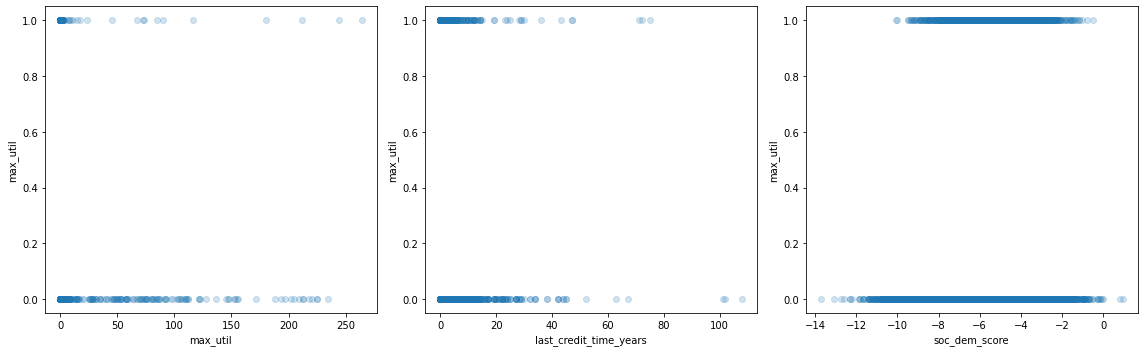

In [ ]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(['max_util', 'last_credit_time_years', 'soc_dem_score']):
    axs[i].scatter(df[feature], df['d4p12'], alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("max_util")
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



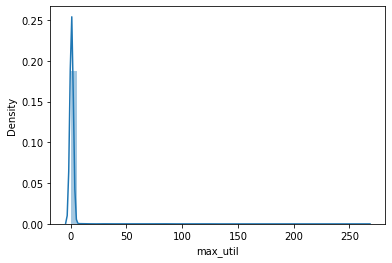

In [ ]:
import plotly.express as px
%matplotlib inline 

sns_plot = sns.distplot(df['max_util'])
fig = sns_plot.get_figure()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



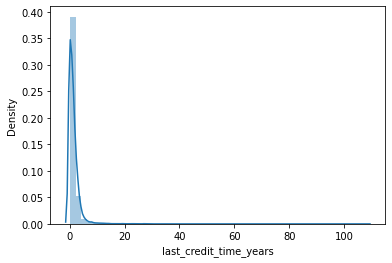

In [ ]:
sns_plot = sns.distplot(df['last_credit_time_years'])
fig = sns_plot.get_figure()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



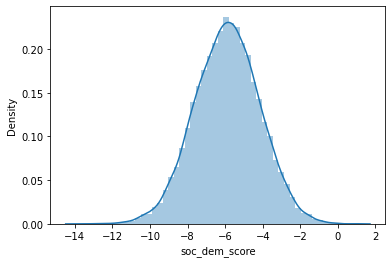

In [ ]:
sns_plot = sns.distplot(df['soc_dem_score'])
fig = sns_plot.get_figure()

3. Построим матрицу корреляций по аналогии семинаром. 

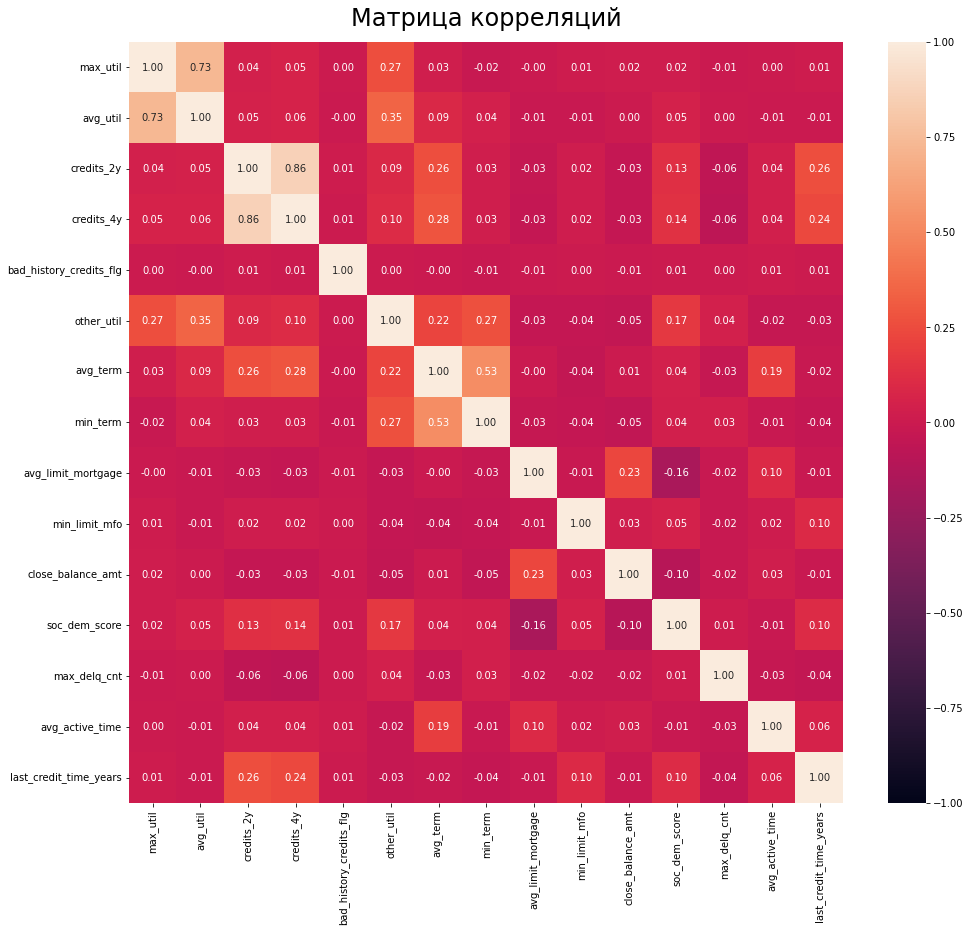

In [ ]:
# построим матрицу корреляций 
plt.figure(figsize=(16, 14))


heatmap = sns.heatmap(df[features].corr(), mask=None, vmin=-1, vmax=1, annot=True, fmt=".2f")
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':24}, pad=16);

Видим, что есть две пары фичей, которые сильно коррелируют друг с другом(коэффициент больше 0.3): 
1. max_util, avg_util
2. min_term, avg_term
3. credit_4y, credit_2y
Достаточно логично почему получились именно эти пары фичей. Мы видим, что это просто различные показатели одних и тех же вещей. То есть по сути, информацию они несут одну и ту же. Поэтому и сильно коррелируют между собой. 
Удалим из пару ту фияу, у которой метрика ROC-AUC получалась ниже. 
Соответственно удалим: avg_util, min_term, credit_2y



4. Настроим градиентный бустинг. Для этого создадим словарь парметров по аналогии с одной из прошлых дз и переберем на имеющихся параметрах комбинации различных гиперпараметров. Обучим модель на трейне с каждой комбинацией гиперпараметров и выберем ту, которая на валидационной выборке дает наилучшее качество. 

In [ ]:
# выкидываем фичи, которые коррелируют друг с другом
features.remove('avg_util')
features.remove('credits_2y')
features.remove('min_term')



In [ ]:
# проверяем, что список фичей именно тот, который нам нужен
features

['max_util',
 'credits_4y',
 'bad_history_credits_flg',
 'other_util',
 'avg_term',
 'avg_limit_mortgage',
 'min_limit_mfo',
 'close_balance_amt',
 'soc_dem_score',
 'max_delq_cnt',
 'avg_active_time',
 'last_credit_time_years']

In [ ]:
# здесь я удалил столбец, который нам больше не нужен 
features.remove('sample_part')


In [ ]:
# удаляем слабые фичи(по ROC-AUC)
features.remove('avg_active_time')
features.remove('avg_term')
features.remove('bad_history_credits_flg')
features.remove('max_delq_cnt')


In [ ]:
# опять же проверяем, что все ок(проверка лишней не бывает!)
features

['max_util',
 'credits_4y',
 'other_util',
 'avg_limit_mortgage',
 'min_limit_mfo',
 'close_balance_amt',
 'soc_dem_score',
 'last_credit_time_years']

In [ ]:
# Здесь я решил сделать по аналогии с одной из прошлых домашек. Я сделал словарь с большим кол-во параметров(так как не хотел перебирать руками).
# Применил прикольную функцию из библиотеки, которая сильно упрощает жизнь в дальнейшем закинул это в функцию
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
# рассмотрим комбинации вот этих параметров
params_dict = {'boosting_type': ['gbdt'], 'n_estimators': [100, 500, 1000], 'learning_rate': [0.5, 0.1, 1e-2],
               'max_depth': [2,3,4], 'num_leaves': [50, 100], 'min_child_samples': [5,10]}

param_list = list(ParameterGrid(params_dict))


In [ ]:
# Разделил наши данные на датафрейм фичей и таргета для каждого типа 
X_train = df[df['sample_part'] == 'train'][features]
y_train = df[df['sample_part'] == 'train']['d4p12']

X_val = df[df['sample_part'] == 'validation'][features]
y_val = df[df['sample_part'] == 'validation']['d4p12']

X_test = df[df['sample_part'] == 'test'][features]
y_test = df[df['sample_part'] == 'test']['d4p12']


In [ ]:
# добавил функцию построения roc_auc кривой(ояень красивая просто, мне нравится )

def roc_auc(y_true, y_pred):
    """Считает ROC AUC
    y_true - метки классов (0/1)
    y_pred - предсказания модели
    """
    n1_all = np.sum(y_true)
    n0_all = len(y_true) - n1_all
    
    df = pd.DataFrame()
    df['y_true'] = y_true
    df['y_pred'] = y_pred
    
    df = df.groupby('y_pred').agg({'y_true' : ['sum', 'count']})
    df.iloc[:, 1] -= df.iloc[:, 0]
    df.columns = ['n1', 'n0']
    
    #df = df.sort_values('y_pred', ascending=False)
    
    df = df.iloc[::-1, :]
    
    tpr = [0]
    fpr = [0]
    roc_auc = 0.0
    
    for i in range(len(df)):
        tpr.append(tpr[-1] + df.iloc[i]['n1'] / n1_all)
        fpr.append(fpr[-1] + df.iloc[i]['n0'] / n0_all)
        roc_auc += (fpr[-1] - fpr[-2]) * (tpr[-1] + tpr[-2]) / 2
        
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], ls='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC AUC = {roc_auc:.3f}')
        
    return roc_auc

In [ ]:
# непосредственно сама функция перебора параметров:
'''
здесь все довольно просто:
для каждой комбинации парметров из моего набора я обучаю бустинг на трейне.
Затем считают качестве на валидационной выборке и выбираю наилучшие парметры. 

'''
def grid_search(X_train, y_train, X_val, y_val, params_list):
  
    max_score = 0
    
    for el in params_list:
        clf = lgb.LGBMClassifier(boosting_type= el['boosting_type'], 
                        n_estimators = el['n_estimators'],
                        learning_rate = el['learning_rate'],
                        max_depth = el['max_depth'],
                        num_leaves = el['num_leaves'],
                        min_child_samples = el['min_child_samples'],
                        random_state = 42)
        
        clf.fit(X_train, y_train) #учим
        y_pred = clf.predict_proba(X_val)[:, 1]
        val_roc_score = roc_auc_score(y_val, y_pred)

        if val_roc_score > max_score:
          max_score = val_roc_score
          best_model = el

    print(f'Лучший roc_auc_score равен {max_score}')
    print(f'Лучшие параметры: {best_model}')
    
    return (best_model)

In [ ]:
best_params = grid_search(X_train, y_train, X_val, y_val, param_list)

Лучший roc_auc_score равен 0.6489468473696789
Лучшие параметры: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 2, 'min_child_samples': 20, 'n_estimators': 500, 'num_leaves': 50}


Здесь я получил оптимальные параметры и самое время посмотреть на качество на тесте 

0.6400743096223069


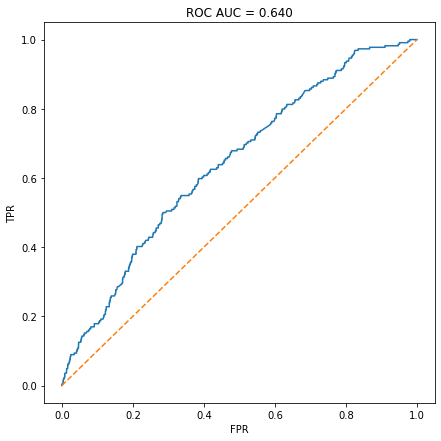

In [ ]:
clf = lgb.LGBMClassifier(boosting_type = best_params['boosting_type'],
                         learning_rate = best_params['learning_rate'],
                         max_depth = best_params['max_depth'],
                         n_estimators = best_params['n_estimators'],
                         num_leaves = best_params['num_leaves'],
                         min_child_samples = best_params['min_child_samples'],
                         random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
roc_auc(y_test, y_pred)
score = roc_auc_score(y_test, y_pred)
print(score)

Качество немного не дотягивает до нужного в условии. Думаю стоило побольше поперебирать различные наборы параметров. В конце пояивлась идея после первого прогона добавить его словарь параметров и попробовать закомбинировать их, но честно говоря времени уже не хватило

5. Посмотрим на самые сильные признаки по gain.

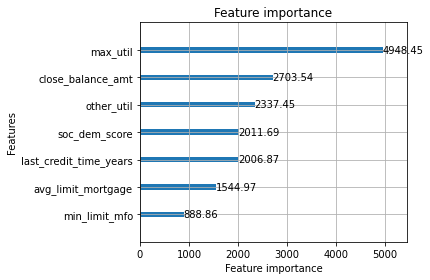

In [ ]:
lgb.plot_importance(clf, importance_type='gain', max_num_features=7, precision=2)
plt.tight_layout()
plt.show()

 Самой важной фичей оказалась max_util. Так как max_util это максимальное отношение кредита к лимиту, то получается, что чем больше значение кредита тем больше становится это значение. То есть, чем больше это значение, тем хуже 

In [ ]:
new_features = ['max_util', 'close_balance_amt', 'soc_dem_score', 'other_util', 'last_credit_time_years', 'min_limit_mfo', 'avg_limit_mortgage']

6. Реализуем stepwise. 

In [ ]:
def likelihood_ratio_test(ll_short, ll_long):
    
    lr = 2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [ ]:
def stepwise_selection(df, features, alpha_in, alpha_out, target='d4p12'):
    # запишем сначала блок с семинара, затем допишем к нему такой блок, в котором мы убираем фичу из нашего множества
    selected_features = list()
    n = df.shape[0]
    p_value = 1
    while True:
        potential_features = list(set(features) - set(selected_features))
        best_feature = ''
        for feature in potential_features:
            temp_features = [feature] + selected_features
            lr_short = LogisticRegression(penalty='none', max_iter=500)
            lr_long = LogisticRegression(penalty='none', max_iter=500)
            if len(selected_features) == 0:
                const = pd.Series([1]*df.shape[0])
                lr_short.fit(np.array(const).reshape(-1, 1), df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(np.array(const).reshape(-1, 1))[:, 1], normalize=False) 
                lr_long.fit(np.array(df[temp_features]).reshape(-1, 1), df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(np.array(df[temp_features]).reshape(-1, 1))[:, 1], normalize=False)
            else:
                lr_short.fit(df[selected_features], df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(df[selected_features])[:, 1], normalize=False)
                lr_long.fit(df[temp_features], df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(df[temp_features])[:, 1], normalize=False)
            if likelihood_ratio_test(ll_short, ll_long) < alpha_in and likelihood_ratio_test(ll_short, ll_long) < p_value:
                p_value = likelihood_ratio_test(ll_short, ll_long)
                best_feature = feature
        if best_feature == '':
            break
        else:
            selected_features.append(best_feature)
            print(f"В модель была добавлена переменная {best_feature}, p-value: {round(p_value, 4)}")

        p_value = 0

        worst_feature = ''
        for feature in selected_features:
            temp_features = selected_features.copy()
            temp_features.remove(feature)
            lr_short = LogisticRegression(penalty='none', max_iter=500)
            lr_long = LogisticRegression(penalty='none', max_iter=500)
            if len(temp_features) == 0:
                const = pd.Series([1]*df.shape[0])
                lr_short.fit(np.array(const).reshape(-1, 1), df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(np.array(const).reshape(-1, 1))[:, 1], normalize=False) 
                lr_long.fit(np.array(df[selected_features]).reshape(-1, 1), df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(np.array(df[selected_features]).reshape(-1, 1))[:, 1], normalize=False)
            else:
                lr_short.fit(df[temp_features], df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(df[temp_features])[:, 1], normalize=False)
                lr_long.fit(df[selected_features], df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(df[selected_features])[:, 1], normalize=False)
            if likelihood_ratio_test(ll_short, ll_long) > alpha_out and likelihood_ratio_test(ll_short, ll_long) > p_value:
                p_value = likelihood_ratio_test(ll_short, ll_long)
                worst_feature = feature
        if worst_feature == '':
              pass
        else:
            selected_features.remove(worst_feature)
            print(f"Из модели была исключена {worst_feature}, p-value: {round(p_value, 4)}")
        p_value = 1
    return selected_features

In [ ]:
final_features = stepwise_selection(df, new_features, 10, 15, target='d4p12')
print(final_features)

В модель была добавлена переменная soc_dem_score, p-value: 0.0
В модель была добавлена переменная last_credit_time_years, p-value: 0.0
В модель была добавлена переменная other_util, p-value: 0.0
В модель была добавлена переменная max_util, p-value: 0.981
['soc_dem_score', 'last_credit_time_years', 'other_util', 'max_util']


In [ ]:
# Сделаем новый трейн, в который добавим и валидационную выборку и трейн. Возможно, это даст нам небольшой прирост в качестве. 

X_new_train = df[(df['sample_part'] == 'train') | (df['sample_part'] == 'validation')][final_features]
y_new_train = df[(df['sample_part'] == 'train') | (df['sample_part'] == 'validation')]['d4p12']

X_new_test = df[df['sample_part'] == 'test'][final_features]

In [ ]:
model = LogisticRegression(penalty='none')
model.fit(X_new_train, y_new_train)

LogisticRegression(penalty='none')

In [ ]:
pred_val = model.predict_proba(X_new_test)[:, 1]

Визуализируем важность признаков аналогично семинару

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(penalty='none', fit_intercept=True, max_iter=1500))])
pipe.fit(df[final_features[:25]][df['sample_part'] == 'train'],\
         df['d4p12'][df['sample_part'] == 'train'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1500, penalty='none'))])

In [ ]:
df['logreg_predict'] = pipe.predict_proba(df[final_features])[:, 1]

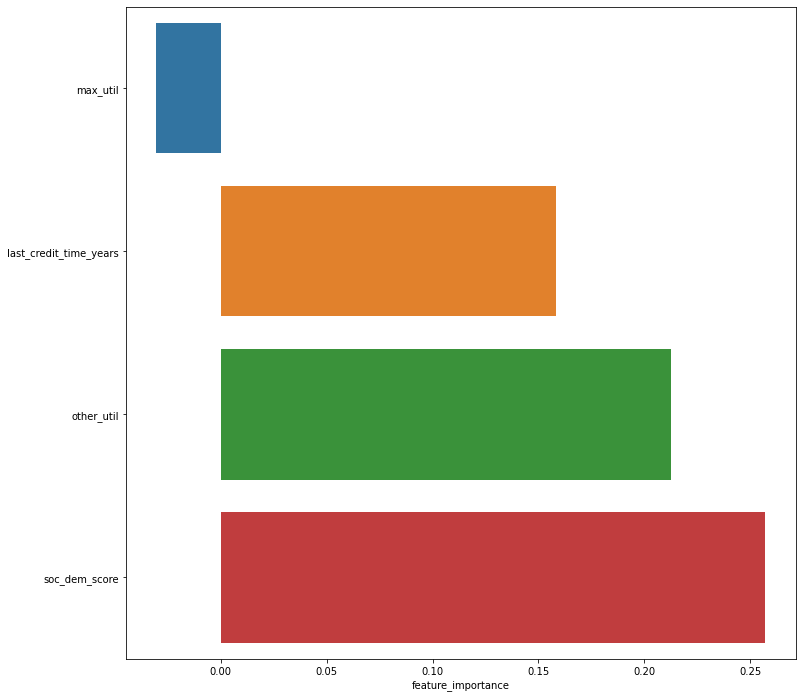

In [ ]:
coef = pd.DataFrame(pipe.get_params()['model'].coef_[0],index=final_features[:25], columns=['feature_importance']).sort_values(by=['feature_importance'])
plot = sns.barplot(y=coef.index, x=coef['feature_importance'])
plot.figure.set_size_inches(12, 12)

Сделаем предикт с помощью логистической регресси на отобранных признаках

0.6196761000376547

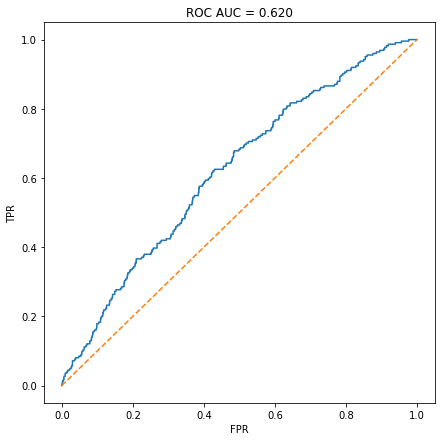

In [ ]:
y_new_test = df[df['sample_part'] == 'test']['d4p12']
score = roc_auc_score(y_new_test, pred_val)
roc_auc(y_new_test, pred_val)

Получилось, что метрика для логистической регрессии оказалось немного хуже, чем для бустинга. Почему так может быть? Во-первых, как мне кажется, бустинг очень хорошо подстраивается для получению необходимого качества за счет своего гибкого настроя гиперпараметров. Во-вторых в силу кол-ва решающих деревьев, бустинг хорошо подстраивается под конкретную задачу. Думаю, что эти причины и могут продвигать его немного вперед в сравнении с логистической регрессией.  

Моя модель не переобучилась. Во-первых, на тесте качество примерно такое же как и на тесте и далеко от 1. Во-вторых, я посмотрел на результат работы градиентного бустинга, а здесь качество оказалось примерно таким же. Из этого можно сделать вывод, что модель не переобучилась. Также это видно из графической интерпритации roc_auc. 

Очень классная домашка.Спасибо)). Хотелось бы конечно уделить ей еще больше времени, но университет, к сожалению, не позволил. 

- [x]  Признаки отобраны по ROC-AUC
- [x]  EDA проведён
- [x]  Корреляты удалены
- [x]  Градиентный бустинг обучен и достигает нужного качества
- [x]  Самые сильные признаки отобраны
- [x] реализован 
- [x]  Линейная модель обучена, проанализирована сила признаков 
- [x]  Метрики на тесте посчитаны
- [x]  Проведено сравнение качества моделей, выдвинуты гипотезы о причинах наблюдаемых результатов